In [1]:
%%capture
!pip install tensorflow_datasets
!pip install --upgrade tensorflow
!pip install opendatasets
!pip install --upgrade skillsnetwork

In [2]:
import numpy as np
import datetime
import os
import random, shutil
import glob
import skillsnetwork

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import opendatasets as od

sns.set_context('notebook')
sns.set_style('white')

2025-08-14 17:18:46.162558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 17:18:46.374901: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 17:18:46.382612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-14 17:18:46.382652: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

2.11.0


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [4]:
dataset_home = 'signs/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['stop/', 'not_stop/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok = True)

In [5]:
for file in listdir("stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"stop/{file}", f"signs/train/stop/{file}")
        
for file in listdir("not_stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"not_stop/{file}", f"signs/train/not_stop/{file}")

test_path = "test_set_stop_not_stop/"
for file in listdir(test_path):
    if file.startswith("stop"):
        shutil.copyfile(test_path+file, f"signs/test/stop/{file}")
    elif file.startswith("not_stop"):
        shutil.copyfile(test_path+file, f"signs/test/not_stop/{file}")      
       

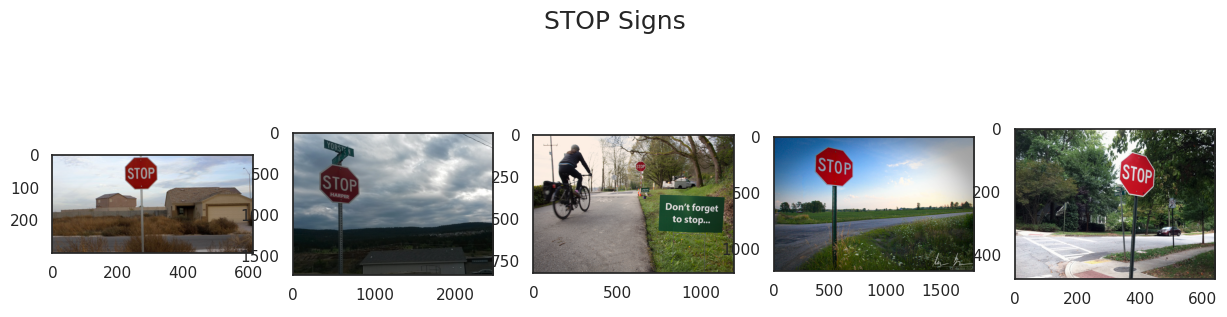

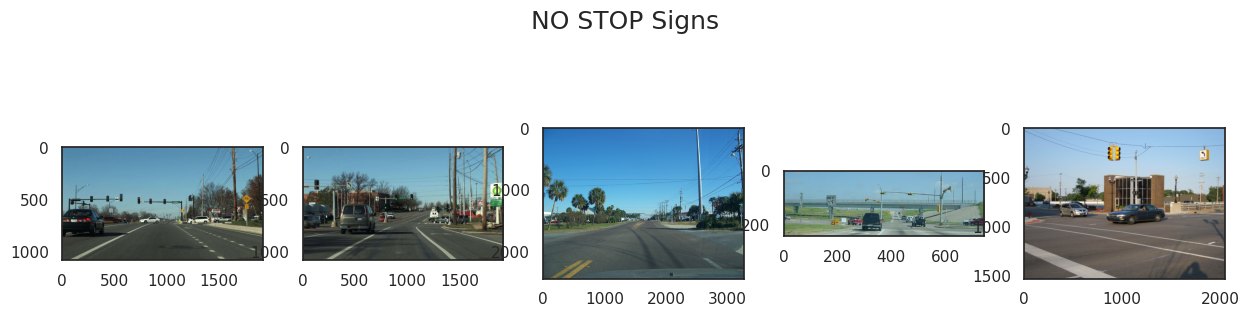

In [6]:
train_stop = glob.glob('./signs/train/stop/*')
train_not_stop = glob.glob('./signs/train/not_stop/*')

fig1, ax1 = plt.subplots(1,5,figsize=(15,4))
fig1.suptitle("STOP Signs", fontsize=18)
l1 = [ax1[i].imshow(imread(train_stop[i])) for i in range(5)]

fig2, ax2 = plt.subplots(1,5,figsize=(15,4))
fig2.suptitle("NO STOP Signs", fontsize=18)
l2 = [ax2[i].imshow(imread(train_not_stop[i])) for i in range(5)]


In [7]:
path = "signs/train/"
labels = ['stop', 'not_stop']
seed = 123
batch_size = 30
target_size = (160, 160)

In [8]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.)


In [9]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'validation'
)

Found 158 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [10]:
print(train_generator.class_indices)

prob2class = lambda x: 'Stop' if x < 0.5 else 'Not Stop' 

{'stop': 0, 'not_stop': 1}


In [11]:
from sklearn.utils import shuffle

test_files = glob.glob('signs/test/stop/*.jpeg') + glob.glob('signs/test/not_stop/*.jpeg')
test_files = shuffle(test_files)

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in test_files]
test_imgs = np.array(test_imgs).astype('int')

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [12]:
def build_compile_fit(basemodel):
    
    # flatten the output of the base model
    x = Flatten()(basemodel.output)
    # add a fully connected layer 
    x = Dense(1024, activation='relu')(x)
    # add dropout layer for regularization
    x = Dropout(0.2)(x)
    # add final layer for classification
    x = Dense(1, activation='sigmoid')(x)

    model = Model(basemodel.input, x)
    model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001),
                                                       loss='binary_crossentropy',
                                                       metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01)]

    model.fit(train_generator,
              validation_data = val_generator,
              steps_per_epoch=5, # num of batches in one epoch
              epochs=10,
              callbacks=callbacks)
    
    return model

### Pre-trained Model 1: Inception-v3


In [13]:
from keras.applications.inception_v3 import InceptionV3

# initialize the base model
basemodel = InceptionV3(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
inception_v3 = build_compile_fit(basemodel)

2025-08-14 17:22:39.587459: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-08-14 17:22:39.587521: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-08-14 17:22:39.587562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterlab-alybilal16): /proc/driver/nvidia/version does not exist
2025-08-14 17:22:39.588116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
5/5 [==============================] - 32s 6s/step - loss: 7.5407 - accuracy: 0.6094 - val_loss: 1.6264 - val_accuracy: 0.5128
Epoch 2/10
5/5 [==============================] - 21s 5s/step - loss: 1.7126 - accuracy: 0.6562 - val_loss: 1.2145 - val_accuracy: 0.7436
Epoch 3/10
5/5 [==============================] - 22s 4s/step - loss: 2.3234 - accuracy: 0.5703 - val_loss: 0.8402 - val_accuracy: 0.7436
Epoch 4/10
5/5 [==============================] - 20s 4s/step - loss: 0.5349 - accuracy: 0.8203 - val_loss: 0.8340 - val_accuracy: 0.7436
Epoch 5/10
5/5 [==============================] - 20s 4s/step - loss: 0.5872 - accuracy: 0.8203 - val_loss: 0.3608 - val_accuracy: 0.8205
Epoch 6/10
5/5 [==============================] - 21s 4s/step - loss: 1.1685 - accuracy: 0.6797 - val_loss: 0.2605 - val_accuracy: 0.8718
Epoch 7/10
5/5 [==============================] - 20s 4s/step - loss: 0.5186 - accuracy: 0.7969 - val_loss:

1/1 [==============================] - 0s 255ms/step


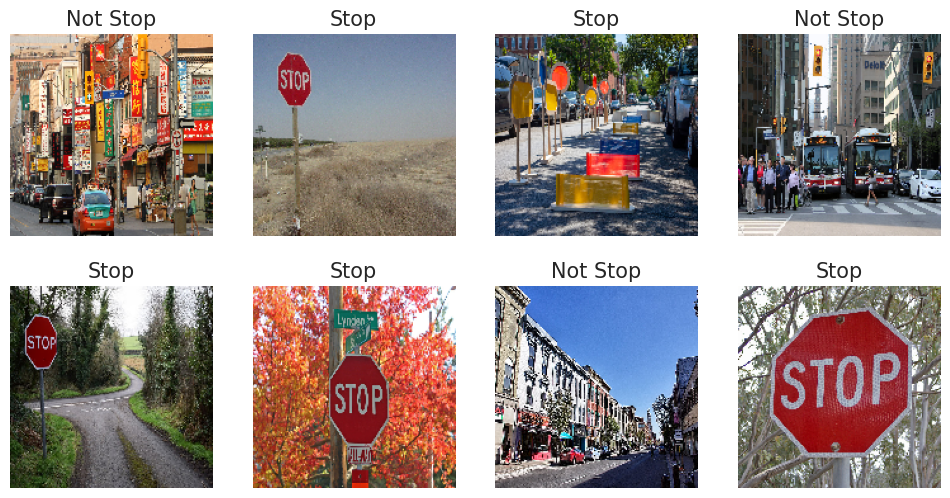

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(inception_v3.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))
    
    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 2: MobileNet


In [15]:
from keras.applications.mobilenet import MobileNet

# initialize the base model
basemodel = MobileNet(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False
    
# call the build_compile_fit function to complete model training
mobile_net = build_compile_fit(basemodel)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/10
5/5 [==============================] - 21s 4s/step - loss: 6.3730 - accuracy: 0.5234 - val_loss: 4.2278 - val_accuracy: 0.4872
Epoch 2/10
5/5 [==============================] - 16s 3s/step - loss: 0.7265 - accuracy: 0.8200 - val_loss: 0.5487 - val_accuracy: 0.7179
Epoch 3/10
5/5 [==============================] - 17s 3s/step - loss: 0.2969 - accuracy: 0.8984 - val_loss: 0.1495 - val_accuracy: 0.9487
Epoch 4/10
5/5 [==============================] - 17s 3s/step - loss: 0.3153 - accuracy: 0.8438 - val_loss: 0.6307 - val_accuracy: 0.6410
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.5613 - accuracy: 0.7969 - val_loss: 0.3737 - val_accuracy: 0.7949
Epoch 6/10
5/5 [==============================] - 16s 4s/step - loss: 0.2629 - accuracy: 0.8828 - val_loss: 0.2138 - val_accuracy: 0.9231
Epoch 7/10
5/5 [==============================] - 17s 4s/step - loss: 0.2932 - accuracy: 0.8672 - val_loss:

1/1 [==============================] - 0s 90ms/step


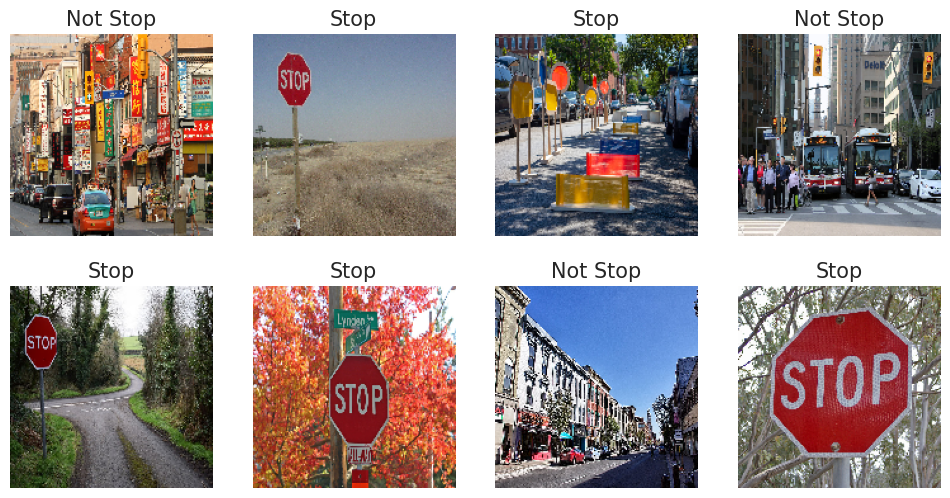

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(mobile_net.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))
    
    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 3: ResNet-50


In [17]:
from keras.applications import ResNet50

# initialize the base model
basemodel = ResNet50(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
resnet_50 = build_compile_fit(basemodel)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
5/5 [==============================] - 35s 6s/step - loss: 1.2145 - accuracy: 0.5625 - val_loss: 0.6967 - val_accuracy: 0.4872
Epoch 2/10
5/5 [==============================] - 29s 7s/step - loss: 1.3836 - accuracy: 0.4531 - val_loss: 0.8577 - val_accuracy: 0.5128
Epoch 3/10
5/5 [==============================] - 28s 5s/step - loss: 0.7686 - accuracy: 0.5234 - val_loss: 0.8558 - val_accuracy: 0.4872
Epoch 4/10
5/5 [==============================] - 29s 6s/step - loss: 0.9973 - accuracy: 0.5078 - val_loss: 0.8281 - val_accuracy: 0.5128
Epoch 5/10
5/5 [==============================] - 27s 5s/step - loss: 0.8576 - accuracy: 0.5078 - val_loss: 1.7813 - val_accuracy: 0.5128
Epoch 6/10
5/5 [==============================] - 27s 5s/step - loss: 0.9889 - accuracy: 0.4688 - val_loss: 0.8721 - val_accuracy: 0.4872
Epoch 7/10
5/5 [==============================] - 28s 5s/step - loss: 0.9162 - accuracy: 0.5234 - val_loss:

1/1 [==============================] - 0s 263ms/step


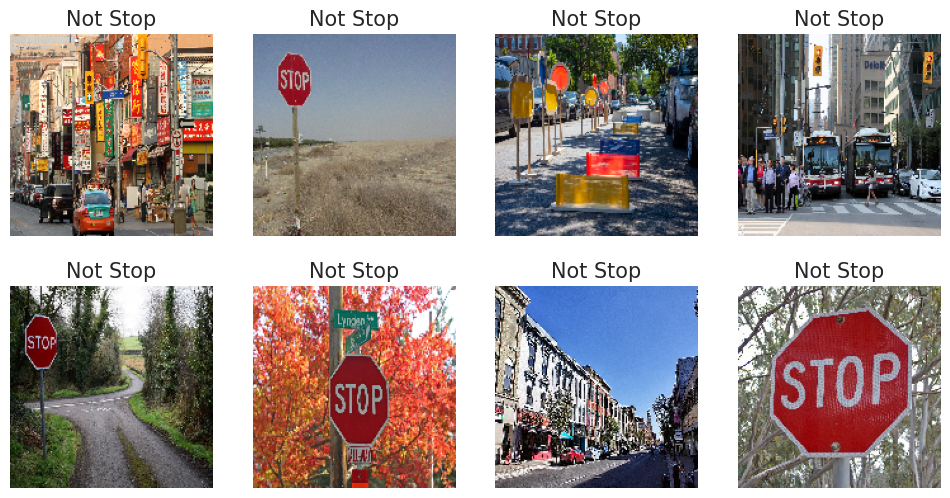

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(resnet_50.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))
    
    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

Predictions of the pre-trained CNN architectures were not very accuratening tasks.For better performance we need to apply finetuning by adding more custom layers on top of the base model

